# Human Activity Recognition (HAR)
Human Activity Recognition (HAR) refers to the capability of machines to identify various activities performed by the users. The knowledge acquired from these systems/algorithms is integrated into many applications where the associated device uses it to identify actions or gestures and performs predefined tasks in response.

## Task 1 : Exploratory Data Analysis (EDA) [3 marks]


#### QUESTION 1

Plot the waveform for one sample data from each activity class. Are you able to see any difference/similarities between the activities? You can plot a subplot having 6 columns to show differences/similarities between the activities. Do you think the model will be able to classify the activities based on the data? **[0.5 marks]**

IMPORTS

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from tsfel import time_series_features_extractor, get_features_by_domain
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [3]:
# Activity labels
ACTIVITIES = ["LAYING", "SITTING", "STANDING", 
              "WALKING", "WALKING_DOWNSTAIRS", "WALKING_UPSTAIRS"]


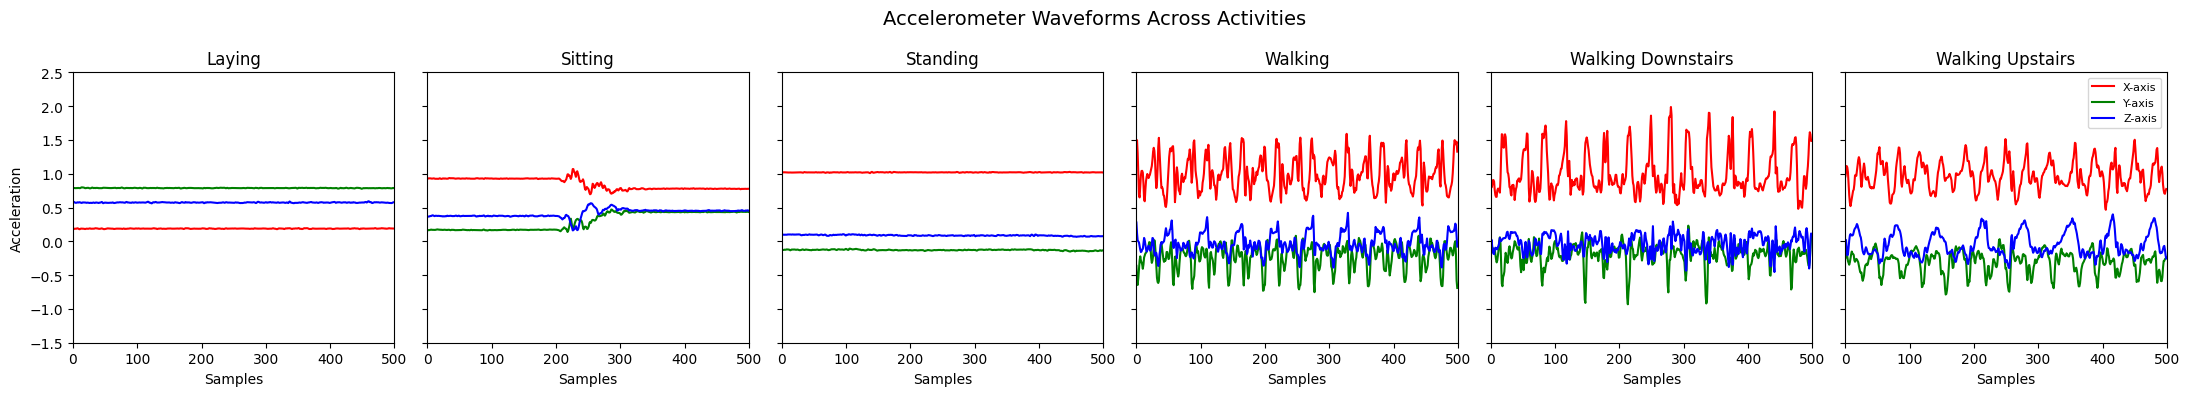

In [6]:

def pick_one_file_per_activity(base_dir):
    """
    Selects one CSV file from each activity folder.
    """
    chosen_files = []
    titles = []
    for activity in ACTIVITIES:
        folder = os.path.join(base_dir, activity)
        file = os.listdir(folder)[0]   # take the first CSV
        chosen_files.append(os.path.join(folder, file))
        titles.append(activity.title().replace("_", " "))
    return chosen_files, titles


def plot_activity_signals(file_paths, titles):
    """
    Plots accelerometer signals (X, Y, Z) for each selected activity.
    """
    fig, axes = plt.subplots(1, 6, figsize=(22, 4), sharey=True)
    fig.suptitle("Accelerometer Waveforms Across Activities", fontsize=14)

    for i, (file, ax) in enumerate(zip(file_paths, axes)):
        # Load one sample and trim to first 500 values
        df = pd.read_csv(file).iloc[:500, :]

        ax.plot(df["accx"], color="red", label="X-axis")
        ax.plot(df["accy"], color="green", label="Y-axis")
        ax.plot(df["accz"], color="blue", label="Z-axis")

        ax.set_title(titles[i])
        ax.set_xlim([0, 500])
        ax.set_ylim([-1.5, 2.5])
        ax.set_xlabel("Samples")
        if i == 0:
            ax.set_ylabel("Acceleration")
        if i == 5:  # show legend only on last subplot
            ax.legend(fontsize=8, loc="upper right")

    plt.tight_layout()
    plt.show()

# -------- MAIN --------
if __name__ == "__main__":
    base_path = os.path.join("Combined", "Train")
    files, titles = pick_one_file_per_activity(base_path)
    plot_activity_signals(files, titles)



Yes, the model should be able to classify the activities. In the waveforms, static activities like sitting, standing, and laying show low or almost flat signals, while dynamic activities like walking, walking upstairs, and walking downstairs produce stronger, periodic variations. These clear differences in amplitude and frequency give the model enough information to distinguish between the activities, although separating similar static activities may be a bit harder.

#### QUESTION 2
Do you think we need a machine learning model to differentiate between static activities (laying, sitting, standing) and dynamic activities(walking, walking_downstairs, walking_upstairs)? Look at the linear acceleration $(acc_x^2+acc_y^2+acc_z^2)$ for each activity and justify your answer. **[0.5 marks]**

No, we don’t necessarily need a machine learning model to separate static from dynamic activities. The linear acceleration (acc²x+acc²y+acc²z) for static activities remains almost constant and low, while for dynamic activities it shows clear oscillations and higher variations. This strong contrast makes it possible to distinguish the two groups even with simple threshold-based methods.

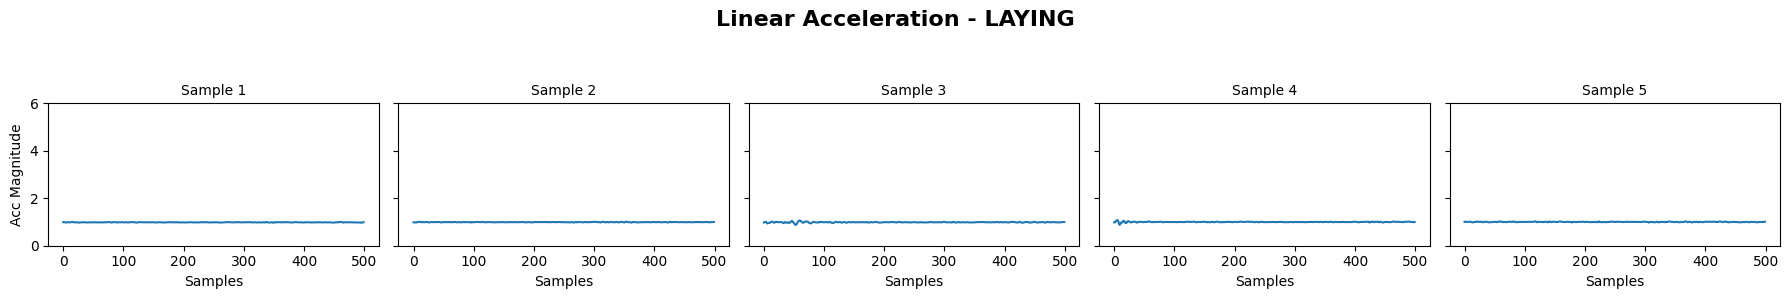

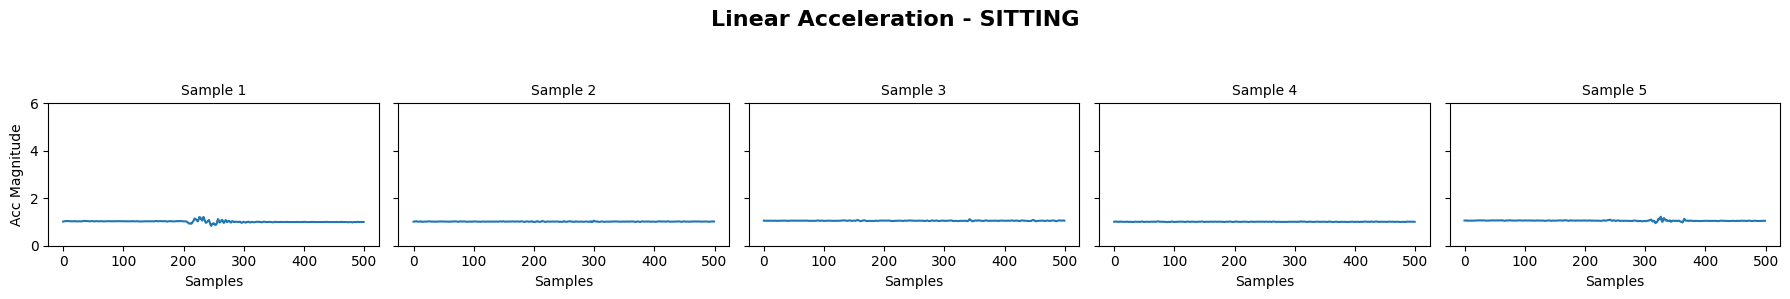

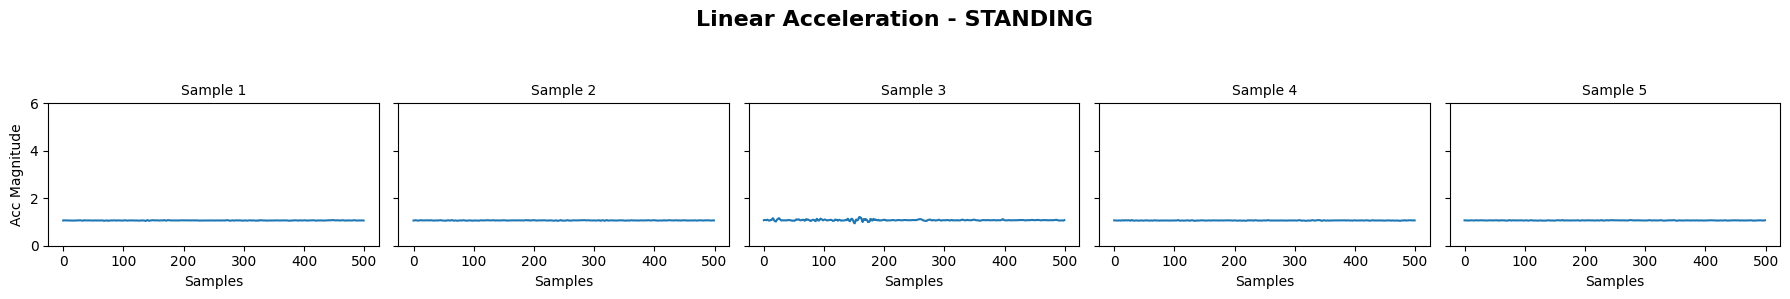

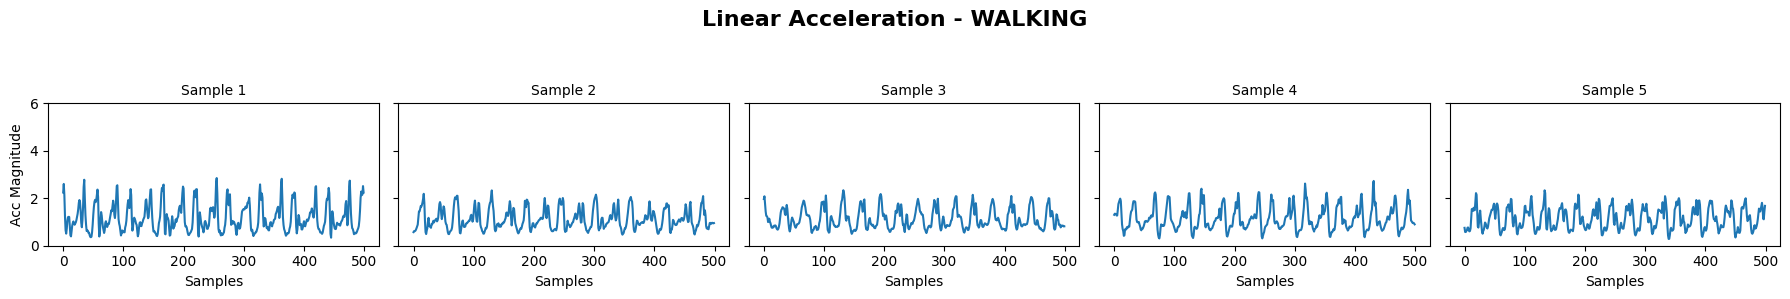

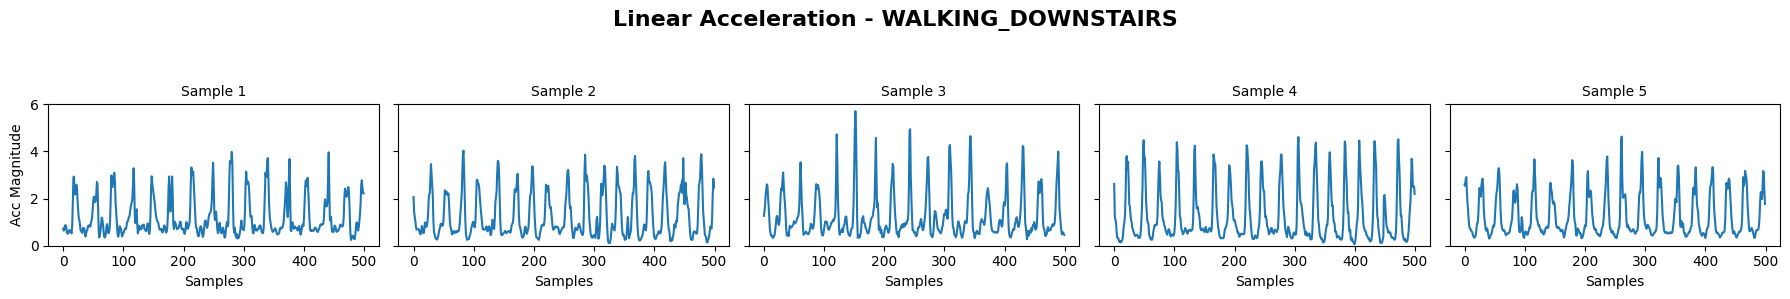

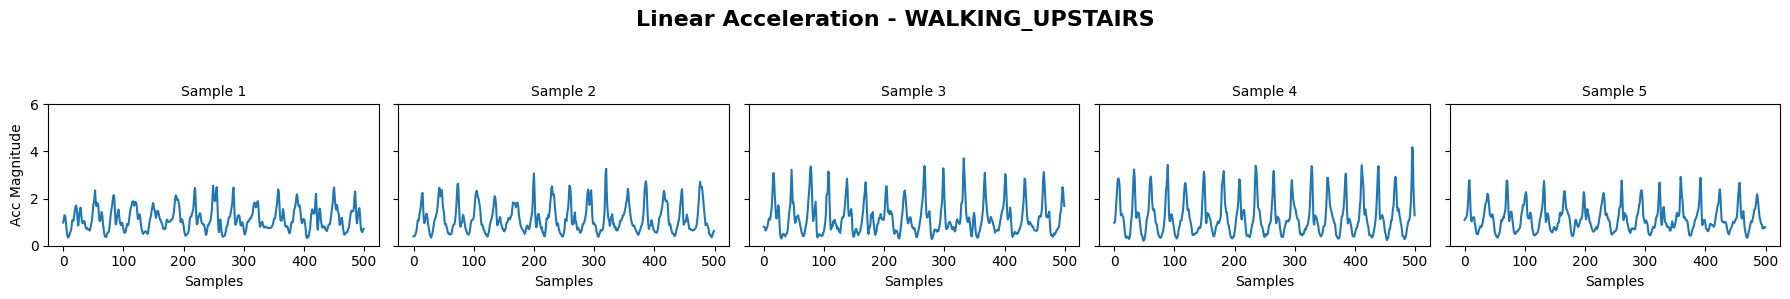

In [7]:
def choose_activity_files(base_dir, samples_per_activity=3):
    """
    Picks a few CSV files for each activity to visualize.
    """
    selected = []
    for activity in ACTIVITIES:
        folder = os.path.join(base_dir, activity)
        files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".csv")]
        selected.extend(files[:samples_per_activity])   # pick first N files
    return selected

def plot_linear_acceleration(file_list):
    """
    Computes and plots the linear acceleration magnitude for chosen samples.
    """
    for idx, activity in enumerate(ACTIVITIES):
        # Create 1 row, 5 columns for each activity
        fig, axes = plt.subplots(1, 5, figsize=(18, 3), sharey=True)
        fig.suptitle(f"Linear Acceleration - {activity}", fontsize=16, fontweight="bold")

        for j in range(5):
            # Load one CSV file, keep first 500 rows
            df = pd.read_csv(file_list[idx*5 + j]).iloc[:500, :]

            # Compute magnitude of acceleration vector
            acc_mag = df["accx"]**2 + df["accy"]**2 + df["accz"]**2

            # Plot each sample
            axes[j].plot(acc_mag)
            axes[j].set_title(f"Sample {j+1}", fontsize=10)
            axes[j].set_ylim([0, 6])
            if j == 0:
                axes[j].set_ylabel("Acc Magnitude")
            axes[j].set_xlabel("Samples")

        plt.tight_layout(rect=[0, 0, 1, 0.9])
        plt.show()

# ---------- MAIN ----------
if __name__ == "__main__":
    dataset_dir = os.path.join("Combined", "Train")
    chosen_files = choose_activity_files(dataset_dir, samples_per_activity=5)
    plot_linear_acceleration(chosen_files)


#### QUESTION 3
3. \Visualize the data using PCA. **[1 marks]**
    * Use PCA (Principal Component Analysis) on Total Acceleration $(acc_x^2+acc_y^2+acc_z^2)$ to compress the acceleration timeseries into two features and plot a scatter plot to visualize different class of activities. 
    *  Next, use [TSFEL](https://tsfel.readthedocs.io/en/latest/) ([a featurizer library](https://github.com/fraunhoferportugal/tsfel)) to create features (your choice which ones you feel are useful) and then perform PCA to obtain two features. Plot a scatter plot to visualize different class of activities. 
    *  Now use the features provided by the dataset and perform PCA to obtain two features. Plot a scatter plot to visualize different class of activities.
    *  Compare the results of PCA on Total Acceleration, TSFEL and the dataset features. Which method do you think is better for visualizing the data? 

Functions

In [9]:
# ---------------- Step 1: Load Raw Accelerometer ----------------
def load_acc_data(base_dir, samples_per_activity=10):
    data, labels = [], []
    for idx, activity in enumerate(ACTIVITIES):
        folder = os.path.join(base_dir, activity)
        files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".csv")]
        for f in files:
            df = pd.read_csv(f)
            # Compute total acceleration magnitude
            acc_mag = (df["accx"]**2 + df["accy"]**2 + df["accz"]**2).values
            data.append(acc_mag[:500])  # keep first 500 samples
            labels.append(activity)
    return np.array(data), np.array(labels)

def apply_pca_and_plot(X, y, title):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    plt.figure(figsize=(8,6))
    for act in np.unique(y):
        idx = np.where(y == act)
        plt.scatter(X_pca[idx,0], X_pca[idx,1], label=act, alpha=0.7)
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.show()


# ---------------- Step 2: TSFEL Features ----------------
def tsfel_features(X, y,feature):
    # Define TSFEL feature set (time + spectral)
    cfg = get_features_by_domain(feature)
    tsfel_feats = []
    for i in range(len(X)):
        series = pd.DataFrame({"acc_mag": X[i]})
        feat = time_series_features_extractor(cfg, series, verbose=0)
        tsfel_feats.append(feat.values.flatten())
    tsfel_feats = np.array(tsfel_feats)
    return tsfel_feats, y


# ---------------- Step 3: Dataset Provided Features ----------------
def load_original_features(dataset_dir):
    # Example: Use X_train.txt from UCI HAR Dataset
    feature_file = os.path.join(dataset_dir, "train", "X_train.txt")
    label_file = os.path.join(dataset_dir, "train", "y_train.txt")

    X = pd.read_csv(feature_file, delim_whitespace=True, header=None).values
    y = pd.read_csv(label_file, delim_whitespace=True, header=None).values.flatten()
    y = np.array([ACTIVITIES[i-1] for i in y])  # map 1–6 → activities
    return X, y


PCA Total Acceleration $(acc_x^2+acc_y^2+acc_z^2)$

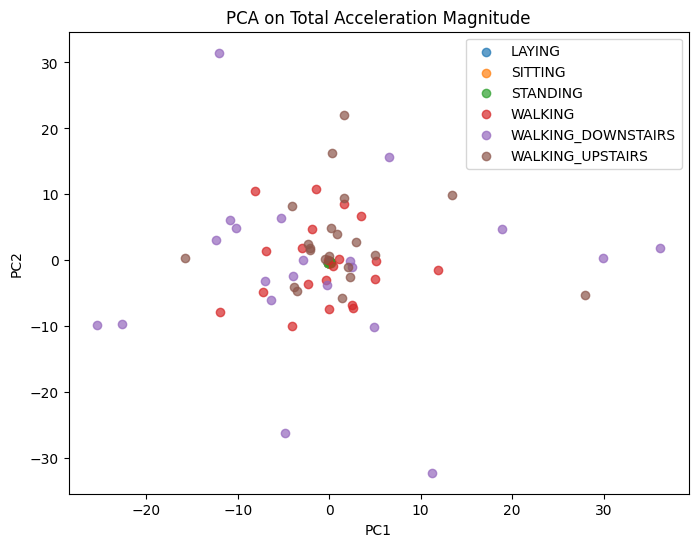

In [10]:

# ---------------- MAIN ----------------
if __name__ == "__main__":
    base_dir = os.path.join("Combined", "Train")

    # Step 1: PCA on total acceleration
    raw_data, raw_labels = load_acc_data(base_dir, samples_per_activity=3)
    apply_pca_and_plot(raw_data, raw_labels, "PCA on Total Acceleration Magnitude")

C:\Users\Aeshaa\AppData\Local\Temp\ipykernel_45656\1084112979.py:39: UserWarning: Using default sampling frequency set in configuration file.
  feat = time_series_features_extractor(cfg, series, verbose=0)
C:\Users\Aeshaa\AppData\Local\Temp\ipykernel_45656\1084112979.py:39: UserWarning: Using default sampling frequency set in configuration file.
  feat = time_series_features_extractor(cfg, series, verbose=0)
C:\Users\Aeshaa\AppData\Local\Temp\ipykernel_45656\1084112979.py:39: UserWarning: Using default sampling frequency set in configuration file.
  feat = time_series_features_extractor(cfg, series, verbose=0)
C:\Users\Aeshaa\AppData\Local\Temp\ipykernel_45656\1084112979.py:39: UserWarning: Using default sampling frequency set in configuration file.
  feat = time_series_features_extractor(cfg, series, verbose=0)
C:\Users\Aeshaa\AppData\Local\Temp\ipykernel_45656\1084112979.py:39: UserWarning: Using default sampling frequency set in configuration file.
  feat = time_series_features_extr

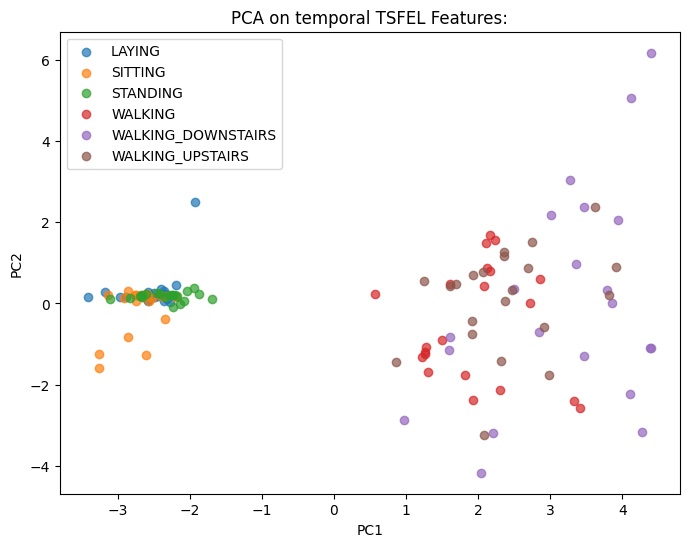

(126, 500)


C:\Users\Aeshaa\AppData\Local\Temp\ipykernel_45656\1084112979.py:39: UserWarning: Using default sampling frequency set in configuration file.
  feat = time_series_features_extractor(cfg, series, verbose=0)
C:\Users\Aeshaa\AppData\Local\Temp\ipykernel_45656\1084112979.py:39: UserWarning: Using default sampling frequency set in configuration file.
  feat = time_series_features_extractor(cfg, series, verbose=0)
C:\Users\Aeshaa\AppData\Local\Temp\ipykernel_45656\1084112979.py:39: UserWarning: Using default sampling frequency set in configuration file.
  feat = time_series_features_extractor(cfg, series, verbose=0)
C:\Users\Aeshaa\AppData\Local\Temp\ipykernel_45656\1084112979.py:39: UserWarning: Using default sampling frequency set in configuration file.
  feat = time_series_features_extractor(cfg, series, verbose=0)
C:\Users\Aeshaa\AppData\Local\Temp\ipykernel_45656\1084112979.py:39: UserWarning: Using default sampling frequency set in configuration file.
  feat = time_series_features_extr

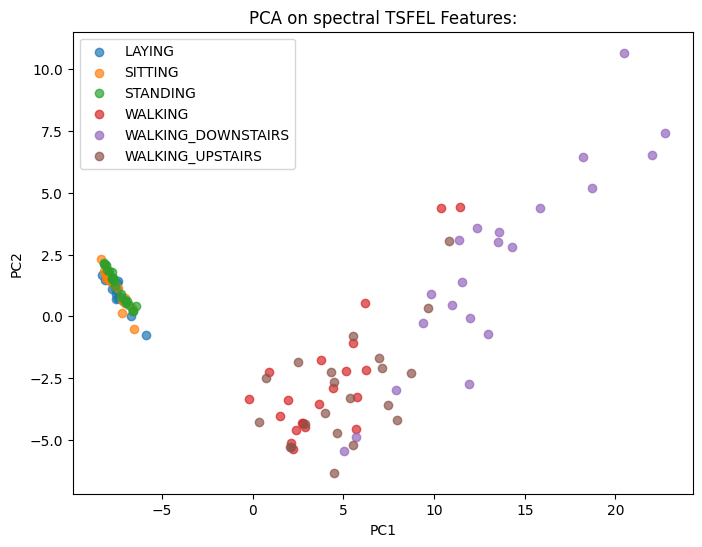

C:\Users\Aeshaa\AppData\Local\Temp\ipykernel_45656\1084112979.py:39: UserWarning: Using default sampling frequency set in configuration file.
  feat = time_series_features_extractor(cfg, series, verbose=0)
C:\Users\Aeshaa\AppData\Local\Temp\ipykernel_45656\1084112979.py:39: UserWarning: Using default sampling frequency set in configuration file.
  feat = time_series_features_extractor(cfg, series, verbose=0)
C:\Users\Aeshaa\AppData\Local\Temp\ipykernel_45656\1084112979.py:39: UserWarning: Using default sampling frequency set in configuration file.
  feat = time_series_features_extractor(cfg, series, verbose=0)
C:\Users\Aeshaa\AppData\Local\Temp\ipykernel_45656\1084112979.py:39: UserWarning: Using default sampling frequency set in configuration file.
  feat = time_series_features_extractor(cfg, series, verbose=0)
C:\Users\Aeshaa\AppData\Local\Temp\ipykernel_45656\1084112979.py:39: UserWarning: Using default sampling frequency set in configuration file.
  feat = time_series_features_extr

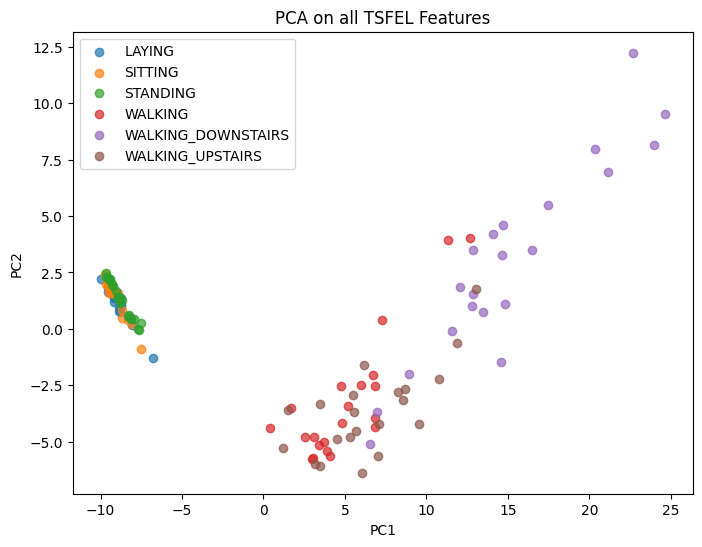

In [11]:
if __name__ == "__main__":
    base_dir = os.path.join("Combined", "Train")
    # Step 2: PCA on TSFEL features
    feature="temporal"
    tsfel_X_1, tsfel_y = tsfel_features(raw_data, raw_labels,feature)
    apply_pca_and_plot(tsfel_X_1, tsfel_y, "PCA on temporal TSFEL Features:")
    print(raw_data.shape)
    
    feature="spectral"
    tsfel_X_2, tsfel_y = tsfel_features(raw_data, raw_labels,feature)
    apply_pca_and_plot(tsfel_X_2, tsfel_y, "PCA on spectral TSFEL Features:")
    
    feature="all"
    tsfel_X_3, tsfel_y = tsfel_features(raw_data, raw_labels,feature)
    apply_pca_and_plot(tsfel_X_3, tsfel_y, "PCA on all TSFEL Features")

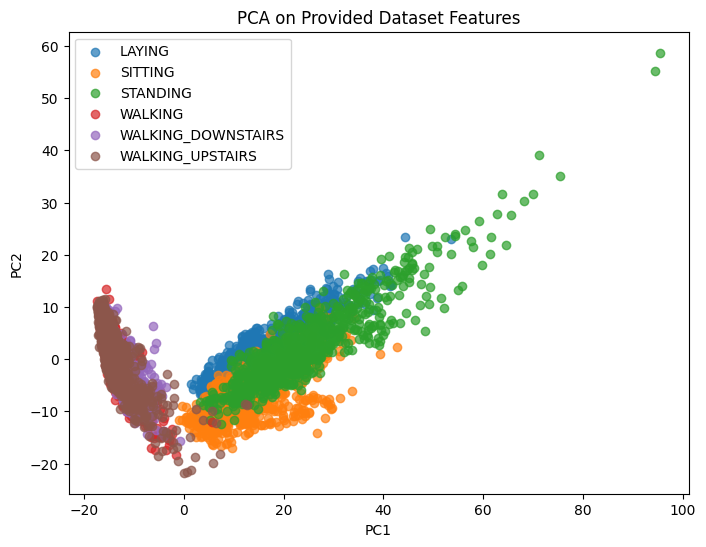

In [12]:
if __name__ == "__main__":
    base_dir = os.path.join("Combined", "Train")
    # Step 3: PCA on dataset-provided features
    feature_dir = os.path.join("UCI HAR Dataset")
    X_feat, y_feat = load_original_features(feature_dir)
    apply_pca_and_plot(X_feat, y_feat, "PCA on Provided Dataset Features")


We can see that the classes are easily seperable in the PCA on the TSFEL features and the UCI HAR dataset features compared to the PCA on the total acceleration. This suggests that we might get better results using the TSFEL features and UCI HAR in a decision tree, better than the raw data. 

#### Question 4
4. Calculate the correlation matrix of the features obtained by TSFEL and provided in the dataset. Identify the features that are highly correlated with each other. Are there any redundant features? **[1 marks]**

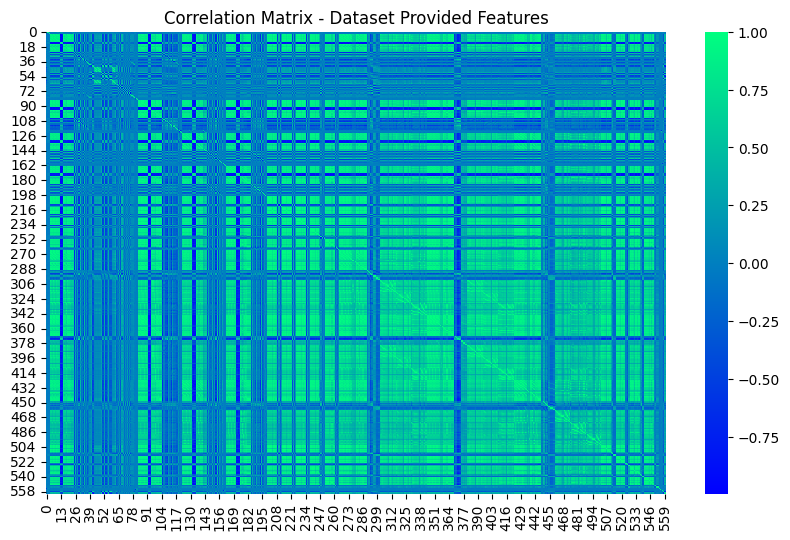

In [13]:
# Convert to DataFrame for correlation calculation
df_dataset = pd.DataFrame(X_feat)

# Correlation matrix
corr_dataset = df_dataset.corr()

# Plot heatmap - Provided dataset features
plt.figure(figsize=(10,6))
sns.heatmap(corr_dataset, cmap="winter", cbar=True)
plt.title("Correlation Matrix - Dataset Provided Features")
plt.show()


In [14]:
# Identify highly correlated feature pairs (|corr| > 0.9)
def find_high_corr(corr_matrix, threshold=0.9):
    corr_pairs = []
    cols = corr_matrix.columns
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            corr_value = corr_matrix.iloc[i, j]
            if abs(corr_value) > threshold:
                corr_pairs.append((cols[i], cols[j], corr_value))
    return corr_pairs

high_corr_pairs = find_high_corr(corr_dataset, threshold=0.98)

print ("Dataset Provided Features")
print("\nHighly correlated feature pairs (|corr| > 0.9):")
for f1, f2, val in high_corr_pairs:
    print(f"{f1}  <-->  {f2} : correlation = {val:.3f}")


Dataset Provided Features

Highly correlated feature pairs (|corr| > 0.9):
3  <-->  6 : correlation = 0.999
3  <-->  9 : correlation = 0.981
3  <-->  19 : correlation = 0.981
3  <-->  265 : correlation = 0.988
3  <-->  268 : correlation = 0.999
3  <-->  271 : correlation = 0.992
4  <-->  7 : correlation = 0.997
4  <-->  266 : correlation = 0.991
4  <-->  269 : correlation = 0.998
4  <-->  272 : correlation = 0.995
5  <-->  8 : correlation = 0.997
5  <-->  270 : correlation = 0.995
5  <-->  273 : correlation = 0.990
6  <-->  19 : correlation = 0.989
6  <-->  265 : correlation = 0.984
6  <-->  268 : correlation = 0.998
6  <-->  271 : correlation = 0.988
7  <-->  20 : correlation = 0.986
7  <-->  266 : correlation = 0.984
7  <-->  269 : correlation = 0.997
7  <-->  272 : correlation = 0.989
8  <-->  21 : correlation = 0.982
8  <-->  270 : correlation = 0.996
8  <-->  273 : correlation = 0.983
9  <-->  271 : correlation = 0.981
15  <-->  200 : correlation = 0.999
15  <-->  205 : correlatio

In [15]:
if len(high_corr_pairs) > 0:
    print("\nThese above features are potentially redundant.")
else:
    print("\nNo strong redundancy found among dataset features.")


These above features are potentially redundant.


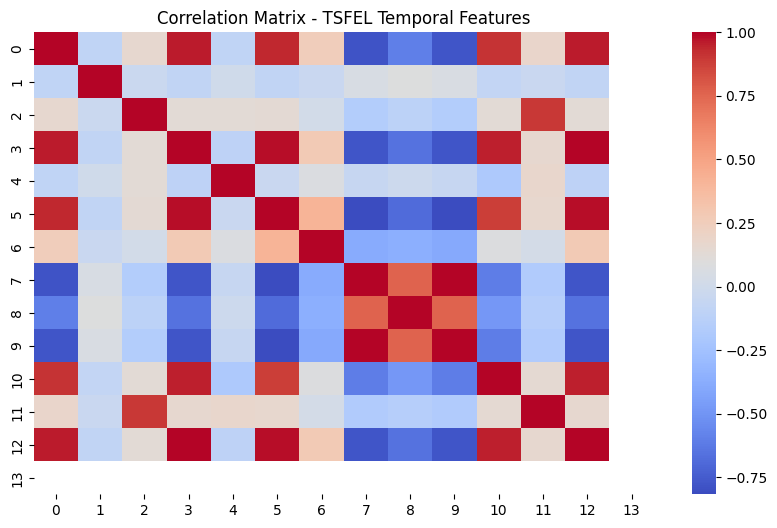

In [16]:
# Convert to DataFrame for correlation calculation
df_tsfel_1 = pd.DataFrame(tsfel_X_1)

# Correlation matrix
corr_tsfel_1 = df_tsfel_1.corr()

# Plot heatmap
plt.figure(figsize=(10,6))
sns.heatmap(corr_tsfel_1, cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix - TSFEL Temporal Features")
plt.show()


In [17]:
print(" TSFEL temporal Features")
high_corr_pairs = find_high_corr(corr_tsfel_1, threshold=0.98)

print("\nHighly correlated feature pairs (|corr| > 0.9):")
for f1, f2, val in high_corr_pairs:
    print(f"{f1}  <-->  {f2} : correlation = {val:.3f}")


 TSFEL temporal Features

Highly correlated feature pairs (|corr| > 0.9):
3  <-->  12 : correlation = 1.000
7  <-->  9 : correlation = 0.999


In [18]:
if len(high_corr_pairs) > 0:
    print("\nThese features are potentially redundant.")
else:
    print("\nNo strong redundancy found among dataset features.")


These features are potentially redundant.


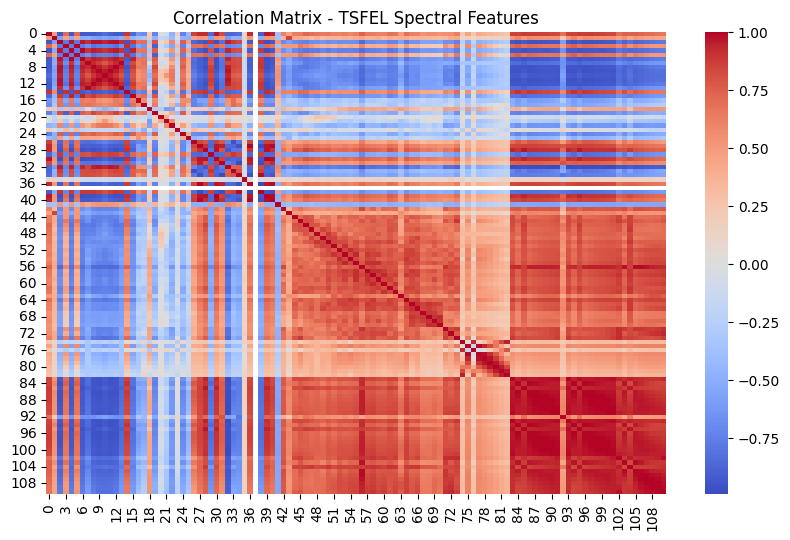

In [19]:
# Convert to DataFrame for correlation calculation
df_tsfel_2 = pd.DataFrame(tsfel_X_2)

# Correlation matrix
corr_tsfel_2 = df_tsfel_2.corr()

# Plot heatmap
plt.figure(figsize=(10,6))
sns.heatmap(corr_tsfel_2, cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix - TSFEL Spectral Features")
plt.show()


In [20]:
print(" TSFEL spectral Features")
high_corr_pairs = find_high_corr(corr_tsfel_2, threshold=0.98)

print("\nHighly correlated feature pairs (|corr| > 0.9):")
for f1, f2, val in high_corr_pairs:
    print(f"{f1}  <-->  {f2} : correlation = {val:.3f}")


 TSFEL spectral Features

Highly correlated feature pairs (|corr| > 0.9):
3  <-->  5 : correlation = 1.000
4  <-->  6 : correlation = 1.000
7  <-->  13 : correlation = 1.000
8  <-->  12 : correlation = 1.000
9  <-->  11 : correlation = 1.000
27  <-->  36 : correlation = 1.000
27  <-->  38 : correlation = -0.986
27  <-->  40 : correlation = 0.990
30  <-->  39 : correlation = 1.000
31  <-->  34 : correlation = -0.990
32  <-->  83 : correlation = -0.986
32  <-->  87 : correlation = -0.981
32  <-->  88 : correlation = -0.980
32  <-->  89 : correlation = -0.980
32  <-->  90 : correlation = -0.983
32  <-->  91 : correlation = -0.987
32  <-->  93 : correlation = -0.986
32  <-->  97 : correlation = -0.981
32  <-->  98 : correlation = -0.980
32  <-->  99 : correlation = -0.980
32  <-->  100 : correlation = -0.983
32  <-->  101 : correlation = -0.987
34  <-->  38 : correlation = 0.984
36  <-->  38 : correlation = -0.986
36  <-->  40 : correlation = 0.990
56  <-->  105 : correlation = 0.990
56  <

In [21]:
if len(high_corr_pairs) > 0:
    print("\nThese features are potentially redundant.")
else:
    print("\nNo strong redundancy found among dataset features.")


These features are potentially redundant.


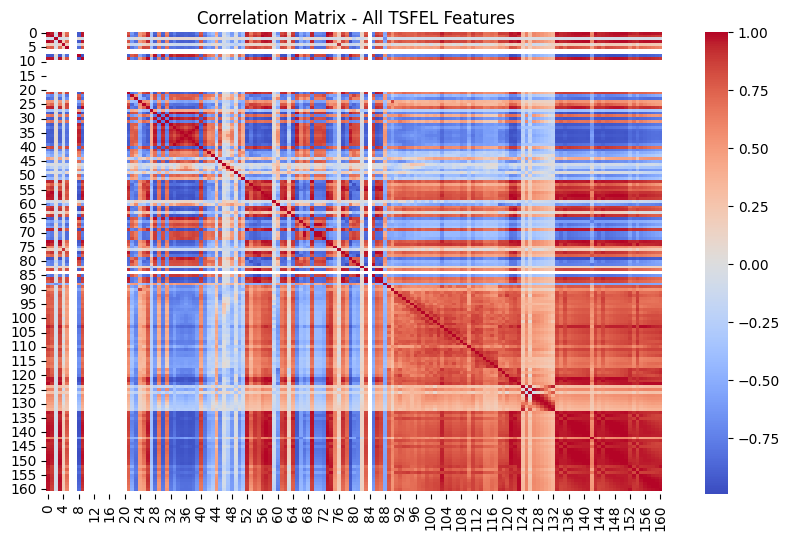

In [22]:
# Convert to DataFrame for correlation calculation
df_tsfel_3 = pd.DataFrame(tsfel_X_3)

# Correlation matrix
corr_tsfel_3 = df_tsfel_3.corr()

# Plot heatmap - All TSFEL features
plt.figure(figsize=(10,6))
sns.heatmap(corr_tsfel_3, cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix - All TSFEL Features")
plt.show()


In [23]:
print("All TSFEL Features")
high_corr_pairs = find_high_corr(corr_tsfel_3, threshold=0.98)

print("\nHighly correlated feature pairs (|corr| > 0.9):")
for f1, f2, val in high_corr_pairs:
    print(f"{f1}  <-->  {f2} : correlation = {val:.3f}")

All TSFEL Features

Highly correlated feature pairs (|corr| > 0.9):
0  <-->  3 : correlation = 1.000
0  <-->  73 : correlation = 0.997
0  <-->  123 : correlation = 0.989
0  <-->  139 : correlation = 0.984
0  <-->  140 : correlation = 0.988
0  <-->  141 : correlation = 0.987
0  <-->  149 : correlation = 0.984
0  <-->  150 : correlation = 0.988
0  <-->  151 : correlation = 0.987
0  <-->  156 : correlation = 0.981
1  <-->  56 : correlation = 1.000
3  <-->  73 : correlation = 0.997
3  <-->  123 : correlation = 0.989
3  <-->  139 : correlation = 0.984
3  <-->  140 : correlation = 0.988
3  <-->  141 : correlation = 0.987
3  <-->  149 : correlation = 0.984
3  <-->  150 : correlation = 0.988
3  <-->  151 : correlation = 0.987
3  <-->  156 : correlation = 0.981
8  <-->  57 : correlation = -0.981
9  <-->  26 : correlation = 0.989
9  <-->  57 : correlation = 0.981
9  <-->  138 : correlation = 0.981
9  <-->  139 : correlation = 0.982
9  <-->  148 : correlation = 0.981
9  <-->  149 : correlation = 

In [24]:
if len(high_corr_pairs) > 0:
    print("\nThese features are potentially redundant.")
else:
    print("\nNo strong redundancy found among dataset features.")


These features are potentially redundant.
